### import

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchsummary import summary
import os
import re
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import einops

### funtions

In [8]:
def get_class(fname):
  return fname.split('_')[1]

def get_sub(fname):
  return fname.split('_')[0]

def integrate_video(fname, path):
    img = Image.open(path + fname).convert('CMYK')
    data = np.expand_dims(np.asarray(img), axis=0)
    for i in range(1, 7):
        fn = fname.replace('_1.jpg',f'_{i+1}.jpg')
        img_ = Image.open(path + fn).convert('CMYK')
        arr = np.expand_dims(np.asarray(img_), axis=0)
        data = np.concatenate((data, arr), axis=0)  # shape: (frame_num, width, height, channel)
    return data

def save_video(files, path):
    ds = []
    sub_dict = []
    class_dict = []
    for f in files:
        data = integrate_video(f, path)
        sub = get_sub(f)
        cls = get_class(f)
        ds.append(data)
        sub_dict.append(sub)
        class_dict.append(cls)

    return ds, sub_dict, class_dict

def get_files_per_class(files):
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ 
    Use for 3-class/in-subclass comparison
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

def get_files_per_sub_per_class(files):
  files_for_sub_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    sub_num = get_sub(fname)
    files_for_sub_for_class[(sub_num, class_name)].append(fname)
  return files_for_sub_for_class

### make dataloader

In [9]:
path = '../image dataset/'
files = os.listdir(path)
sub_num = 5
files_head = [f for f in files if re.match(r'^sub' + str(sub_num) + '.*_1\.jpg$', f)]

data, sub_dict, class_dict = save_video(files_head, path)

files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

NUM_CLASSES = 2
FILES_PER_CLASS = 90   # 270 trials for each sub, 45 trials for each class per sub, 315 trials for each class in general

files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

files_for_sub_for_class = get_files_per_sub_per_class(files)
classes_2stage = list(files_for_sub_for_class.keys())

print('Num classes * subjects:', len(classes_2stage))
print('Num videos for class[0]:', len(files_for_sub_for_class[classes_2stage[0]]))

trial_dict = {'front':0, 'back':1, 'left':2, 'right':3, 'up':4, 'down':5}
label = [trial_dict[x] for x in class_dict]

x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_24412\1573673543.py:4: SyntaxWarning: invalid escape sequence '\.'
  files_head = [f for f in files if re.match(r'^sub' + str(sub_num) + '.*_1\.jpg$', f)]


Num classes: 6
Num videos for class[0]: 2205
Num classes * subjects: 42
Num videos for class[0]: 315


In [10]:
# Custom dataset class
class video_classification_dataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = [torch.tensor(x, dtype=torch.float32) for x in x_data]
        self.y_data = torch.tensor(y_data, dtype=torch.long)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

# Creating datasets
train_dataset = video_classification_dataset(x_train, y_train)
test_dataset = video_classification_dataset(x_test, y_test)

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Now train_dataloader and test_dataloader are ready to be used


### define model

In [11]:
HEIGHT = 369
WIDTH = 433
input_shape = (None, 7, HEIGHT, WIDTH, 4)

def calculate_padding(kernel_size, stride, dilation):
    return ((kernel_size - 1) * dilation + 1 - stride) // 2

# Define Custom Layers and Model
class Conv2Plus1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(Conv2Plus1D, self).__init__()
        # Spatial decomposition
        spatial_kernal = (1, kernel_size[1], kernel_size[2])
        self.spatial_conv = nn.Conv3d(in_channels=in_channels, 
                                      out_channels=out_channels, 
                                      kernel_size=spatial_kernal, 
                                      stride=stride, 
                                      padding=tuple(calculate_padding(k, stride=1, dilation=1) for k in spatial_kernal))
        # Temporal decomposition
        temporal_kernal =(kernel_size[0], 1, 1)
        self.temporal_conv = nn.Conv3d(in_channels=out_channels, 
                                       out_channels=out_channels, 
                                       kernel_size=temporal_kernal, 
                                       stride=stride, 
                                       padding=tuple(calculate_padding(k, stride=1, dilation=1) for k in temporal_kernal))

    def forward(self, x):
        # print("start conv2plus1d")
        # print(x.shape)
        x = self.spatial_conv(x)
        # print("spatial conv done")
        x = self.temporal_conv(x)
        # print("temporal conv done")
        return x

class ResidualMain(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, current_height, current_width):
        super(ResidualMain, self).__init__()
        self.conv1 = Conv2Plus1D(in_channels=in_channels, 
                                 out_channels=out_channels, 
                                 kernel_size=kernel_size, 
                                 stride=stride)
        self.bn1 = nn.LayerNorm([out_channels, 7, current_height, current_width])  # Adjust the size accordingly ????
        self.relu = nn.ReLU()
        self.conv2 = Conv2Plus1D(in_channels=out_channels, 
                                 out_channels=out_channels, 
                                 kernel_size=kernel_size, 
                                 stride=stride)
        self.bn2 = nn.LayerNorm([out_channels, 7,current_height, current_width]) # ???

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return out

class Project(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Project, self).__init__()
        self.fc = nn.Linear(in_channels, out_channels)
        self.bn = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        return x

def add_residual_block(input, in_channels, out_channels, kernel_size, stride):
    out = ResidualMain(in_channels, out_channels, kernel_size, stride)(input)
    res = input
    if out.shape != input.shape:
        res = Project(input.shape[-1], out.shape[-1])(res)
    return out + res


class ResizeVideo(nn.Module):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width

    def forward(self, video):
        """
        Resize the tensor representing a video to a new height and width.

        Args:
          video: Tensor representation of the video, in the form of [batch_size, channels, frames, height, width]

        Return:
          Resized video tensor: [batch_size, channels, frames, new_height, new_width]
        """
        # Parse the original shape
        old_shape = einops.parse_shape(video, 'b c t h w')
        
        # First, permute the video to [batch_size, frames, height, width, channels] 
        video = video.permute(0, 2, 3, 4, 1)  # From [b, c, t, h, w] to [b, t, h, w, c]
        
        # Reshape the video to [(batch_size * frames), height, width, channels]
        images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
        
        # Permute for interpolation: [batch_size * frames, channels, height, width]
        images = images.permute(0, 3, 1, 2)
        
        # Resize the images using torch.nn.functional.interpolate
        resized_images = F.interpolate(images, size=(self.height, self.width), mode='bilinear', align_corners=False)
        
        # Permute back to [(batch_size * frames), height, width, channels]
        resized_images = resized_images.permute(0, 2, 3, 1)
        
        # Reshape back to [batch_size, frames, new_height, new_width, channels]
        videos = einops.rearrange(resized_images, '(b t) h w c -> b t h w c', t=old_shape['t'])
        
        # Finally, permute back to the original format: [batch_size, channels, frames, new_height, new_width]
        videos = videos.permute(0, 4, 1, 2, 3)  # From [b, t, h, w, c] to [b, c, t, h, w]
        
        return videos


class VideoClassificationModel(nn.Module):
    def __init__(self):
        super(VideoClassificationModel, self).__init__()
        self.conv1 = Conv2Plus1D(in_channels=4, 
                                 out_channels=16, 
                                 kernel_size=(3, 7, 7), 
                                 stride=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(16)
        self.relu = nn.ReLU()
        self.resize1 = ResizeVideo(HEIGHT // 2, WIDTH // 2)

        # Residual blocks
        # block 1
        self.block1 = ResidualMain(16, 16, (3, 3, 3), (1, 1, 1), 
                                   current_height=HEIGHT // 2, current_width=WIDTH // 2)
        self.resize2 = ResizeVideo(HEIGHT // 4, WIDTH // 4)
        # block 2
        self.block2 = ResidualMain(16, 32, (3, 3, 3), (1, 1, 1),
                                   current_height=HEIGHT // 4, current_width=WIDTH // 4)
        self.resize3 = ResizeVideo(HEIGHT // 8, WIDTH // 8)
        # block 3
        self.block3 = ResidualMain(32, 64, (3, 3, 3), (1, 1, 1),
                                   current_height=HEIGHT // 8, current_width=WIDTH // 8)
        self.resize4 = ResizeVideo(HEIGHT // 16, WIDTH // 16)
        # block 4
        self.block4 = ResidualMain(64, 128, (3, 3, 3), (1, 1, 1),
                                   current_height=HEIGHT // 16, current_width=WIDTH // 16)

        # Classification
        self.global_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Linear(128, 6)

    def forward(self, x):
        # print("start")
        x = x.permute(0, 4, 1, 2, 3)  # From [8, 7, 369, 433, 4](b t h w c) -> [8, 4, 7, 369, 433](b c t h w)
        x = self.conv1(x)
        # print("conv1 done.")
        x = self.bn1(x)
        # print("bn1 done.")
        x = self.relu(x)
        # print("relu done.")
        x = self.resize1(x)
        # print("resize1 done.")

        # print(x.shape)
        x = self.block1(x)
        # print("block1 done.")
        x = self.resize2(x)
        # print("resize2 done.")
        x = self.block2(x)
        # print("block2 done.")
        x = self.resize3(x)
        # print("resize3 done.")
        x = self.block3(x)
        # print("block3 done.")
        x = self.resize4(x)
        # print("resize4 done.")
        x = self.block4(x)
        # print("block4 done.")

        x = self.global_pool(x)
        # print("global pool done.")
        x = x.view(x.size(0), -1) # flatten ??
        # print("flatten done.")
        x = self.fc(x)
        # print("linear done")
        return x


In [15]:
# Training setup
model = VideoClassificationModel()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# summary(model, input_size=(7, 369, 433, 4))

### training

In [13]:
# # Training loop
# num_epochs = 60
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for videos, labels in train_dataloader:
#         videos, labels = videos.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(videos)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

# print("Training complete.")

KeyboardInterrupt: 

Epoch [1/60], Train Loss: 1.9145, Test Loss: 1.8298
Epoch [2/60], Train Loss: 1.8174, Test Loss: 1.8234
Epoch [3/60], Train Loss: 1.8050, Test Loss: 1.8391
Epoch [4/60], Train Loss: 1.8020, Test Loss: 1.8238
Epoch [5/60], Train Loss: 1.8058, Test Loss: 1.8429
Epoch [6/60], Train Loss: 1.7992, Test Loss: 1.8363
Epoch [7/60], Train Loss: 1.8063, Test Loss: 1.8338
Epoch [8/60], Train Loss: 1.8001, Test Loss: 1.8297
Epoch [9/60], Train Loss: 1.7962, Test Loss: 1.8081
Epoch [10/60], Train Loss: 1.8036, Test Loss: 1.8309
Epoch [11/60], Train Loss: 1.7912, Test Loss: 1.8122
Epoch [12/60], Train Loss: 1.7884, Test Loss: 1.8234
Epoch [13/60], Train Loss: 1.7930, Test Loss: 1.8384
Epoch [14/60], Train Loss: 1.7945, Test Loss: 1.8382
Epoch [15/60], Train Loss: 1.7948, Test Loss: 1.8079
Epoch [16/60], Train Loss: 1.7856, Test Loss: 1.8416
Epoch [17/60], Train Loss: 1.7850, Test Loss: 1.8373
Epoch [18/60], Train Loss: 1.7872, Test Loss: 1.8247
Epoch [19/60], Train Loss: 1.7961, Test Loss: 1.8392
Ep

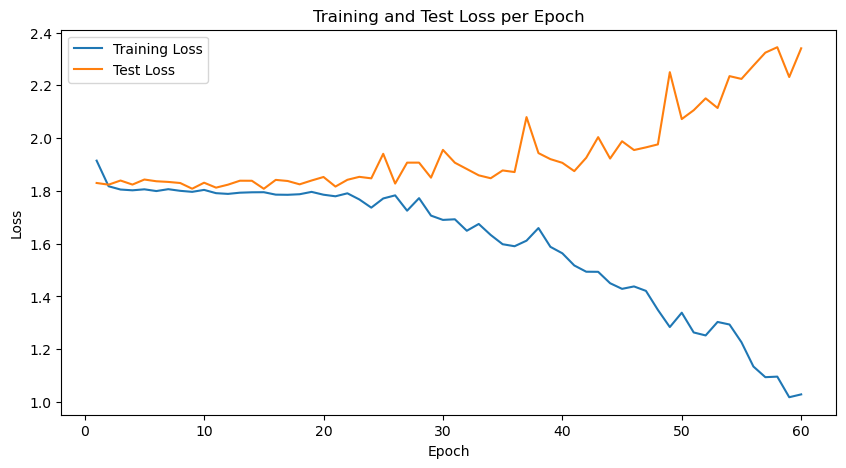

In [16]:
import matplotlib.pyplot as plt

# Arrays to store loss values
train_losses = []
test_losses = []

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for videos, labels in train_dataloader:
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Average training loss for the epoch
    epoch_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)

    # Evaluation on test set
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for videos, labels in test_dataloader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    # Average test loss for the epoch
    epoch_test_loss = running_test_loss / len(test_dataloader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

print("Training complete.")

# Plotting the training and test losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss per Epoch")
plt.legend()
plt.show()


GPU: 192 minute
Epoch [1/60], Loss: 1.9020
Epoch [2/60], Loss: 1.8358
Epoch [3/60], Loss: 1.8099
Epoch [4/60], Loss: 1.7989
Epoch [5/60], Loss: 1.7964
Epoch [6/60], Loss: 1.8126
Epoch [7/60], Loss: 1.7876
Epoch [8/60], Loss: 1.8225
Epoch [9/60], Loss: 1.7989
Epoch [10/60], Loss: 1.8250
Epoch [11/60], Loss: 1.8006
Epoch [12/60], Loss: 1.7968
Epoch [13/60], Loss: 1.7946
Epoch [14/60], Loss: 1.7941
Epoch [15/60], Loss: 1.8016
Epoch [16/60], Loss: 1.7952
Epoch [17/60], Loss: 1.7981
Epoch [18/60], Loss: 1.7864
Epoch [19/60], Loss: 1.7988
Epoch [20/60], Loss: 1.7936
Epoch [21/60], Loss: 1.7937
Epoch [22/60], Loss: 1.7913
Epoch [23/60], Loss: 1.7948
Epoch [24/60], Loss: 1.7912
Epoch [25/60], Loss: 1.7884
Epoch [26/60], Loss: 1.7911
Epoch [27/60], Loss: 1.7840
Epoch [28/60], Loss: 1.7830
Epoch [29/60], Loss: 1.7817
Epoch [30/60], Loss: 1.7783
Epoch [31/60], Loss: 1.7810
Epoch [32/60], Loss: 1.7711
Epoch [33/60], Loss: 1.7825
Epoch [34/60], Loss: 1.8060
Epoch [35/60], Loss: 1.7764
Epoch [36/60], Loss: 1.7675
Epoch [37/60], Loss: 1.7619
Epoch [38/60], Loss: 1.7634
Epoch [39/60], Loss: 1.7374
Epoch [40/60], Loss: 1.7317
Epoch [41/60], Loss: 1.7217
Epoch [42/60], Loss: 1.6897
Epoch [43/60], Loss: 1.7085
Epoch [44/60], Loss: 1.6920
Epoch [45/60], Loss: 1.6602
Epoch [46/60], Loss: 1.6568
Epoch [47/60], Loss: 1.6367
Epoch [48/60], Loss: 1.6097
Epoch [49/60], Loss: 1.5741
Epoch [50/60], Loss: 1.6401
Epoch [51/60], Loss: 1.5483
Epoch [52/60], Loss: 1.5279
Epoch [53/60], Loss: 1.5150
Epoch [54/60], Loss: 1.4782
Epoch [55/60], Loss: 1.4576
Epoch [56/60], Loss: 1.4164
Epoch [57/60], Loss: 1.4771
Epoch [58/60], Loss: 1.4401
Epoch [59/60], Loss: 1.4241
Epoch [60/60], Loss: 1.3739
Training complete.

CPU: 74 minute

Epoch [1/60], Loss: 1.9036
Epoch [2/60], Loss: 1.8069
Epoch [3/60], Loss: 1.8014
Epoch [4/60], Loss: 1.8042
Epoch [5/60], Loss: 1.8018
Epoch [6/60], Loss: 1.8035
Epoch [7/60], Loss: 1.8105
Epoch [8/60], Loss: 1.7973
Epoch [9/60], Loss: 1.7974
Epoch [10/60], Loss: 1.8198
Epoch [11/60], Loss: 1.7985
Epoch [12/60], Loss: 1.8012
Epoch [13/60], Loss: 1.8003
Epoch [14/60], Loss: 1.7804
Epoch [15/60], Loss: 1.7791
Epoch [16/60], Loss: 1.7583
Epoch [17/60], Loss: 1.7618
Epoch [18/60], Loss: 1.7744
Epoch [19/60], Loss: 1.7900
Epoch [20/60], Loss: 1.7752
Epoch [21/60], Loss: 1.7438
Epoch [22/60], Loss: 1.7747
Epoch [23/60], Loss: 1.7700
Epoch [24/60], Loss: 1.7472
Epoch [25/60], Loss: 1.7475
Epoch [26/60], Loss: 1.7198
Epoch [27/60], Loss: 1.7094
Epoch [28/60], Loss: 1.7138
Epoch [29/60], Loss: 1.7001
Epoch [30/60], Loss: 1.7092
Epoch [31/60], Loss: 1.7307
Epoch [32/60], Loss: 1.6988
Epoch [33/60], Loss: 1.7028
Epoch [34/60], Loss: 1.6474
Epoch [35/60], Loss: 1.6620
Epoch [36/60], Loss: 1.6652
Epoch [37/60], Loss: 1.6289
Epoch [38/60], Loss: 1.7001
Epoch [39/60], Loss: 1.6803
Epoch [40/60], Loss: 1.6837
Epoch [41/60], Loss: 1.6284
Epoch [42/60], Loss: 1.5778
Epoch [43/60], Loss: 1.5745
Epoch [44/60], Loss: 1.5707
Epoch [45/60], Loss: 1.5643
Epoch [46/60], Loss: 1.6160
Epoch [47/60], Loss: 1.5600
Epoch [48/60], Loss: 1.5426
Epoch [49/60], Loss: 1.5802
Epoch [50/60], Loss: 1.4987
Epoch [51/60], Loss: 1.4574
Epoch [52/60], Loss: 1.4615
Epoch [53/60], Loss: 1.4991
Epoch [54/60], Loss: 1.4839
Epoch [55/60], Loss: 1.3976
Epoch [56/60], Loss: 1.3974
Epoch [57/60], Loss: 1.3925
Epoch [58/60], Loss: 1.4415
Epoch [59/60], Loss: 1.3526
Epoch [60/60], Loss: 1.3960
Training complete.